In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lizapuspitap","key":"9ee8219d54e4d1e6ccd2e44d3e7937bf"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [3]:
!kaggle datasets download -d rakannimer/air-passengers

  0% 0.00/764 [00:00<?, ?B/s]
100% 764/764 [00:00<00:00, 1.60MB/s]


In [4]:
!mkdir air-passengers
!unzip air-passengers.zip -d air-passengers
!ls air-passengers

Archive:  air-passengers.zip
  inflating: air-passengers/AirPassengers.csv  
AirPassengers.csv


In [5]:
import pandas as pd
import numpy as np

# library untuk lvisualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# library untuk analisis time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# library yang digunakan untuk forecasting
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [6]:
df = pd.read_csv("/content/air-passengers/AirPassengers.csv")

In [7]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [9]:
df.shape

(144, 2)

In [10]:
df.isnull().sum()

Month          0
#Passengers    0
dtype: int64

In [11]:
df['Month'] = pd.to_datetime(df['Month'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [13]:
df.set_index("Month",inplace=True)

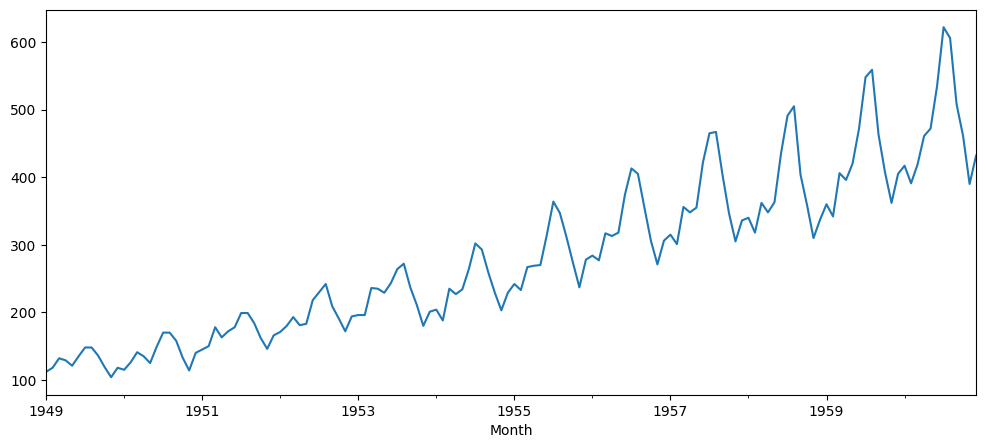

In [15]:
df['#Passengers'].plot(figsize=(12,5));

In [16]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [17]:
df.index.min(), df.index.max()

(Timestamp('1949-01-01 00:00:00'), Timestamp('1960-12-01 00:00:00'))

In [18]:
train = df.iloc[:100]
test = df.iloc[101:]

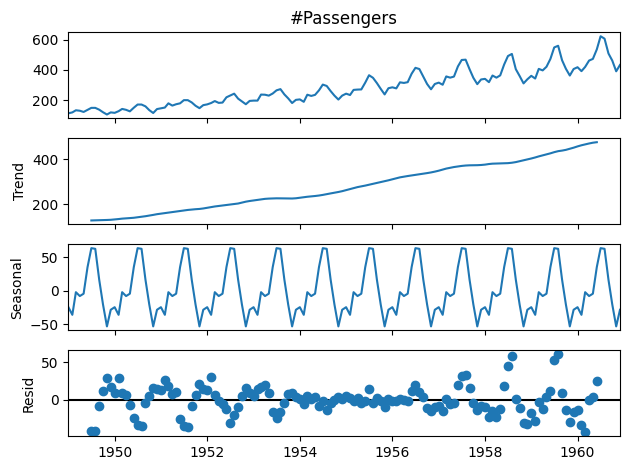

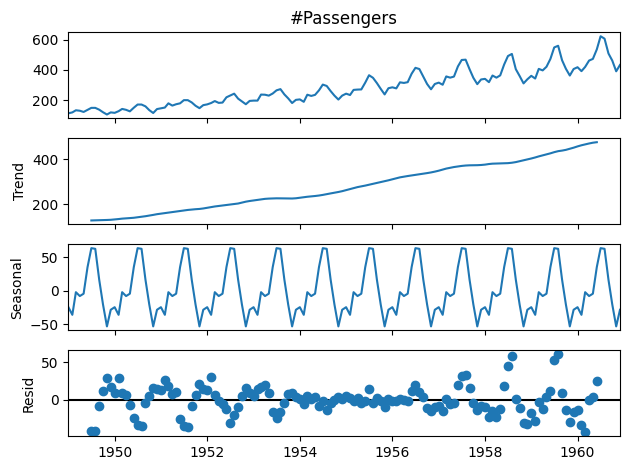

In [19]:
decompose_add = seasonal_decompose(df['#Passengers'])
decompose_add.plot()

In [20]:
diff_df = df.diff()
diff_df.head()

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,6.0
1949-03-01,14.0
1949-04-01,-3.0
1949-05-01,-8.0


In [21]:
diff_df.dropna(inplace=True)

<Axes: xlabel='Month'>

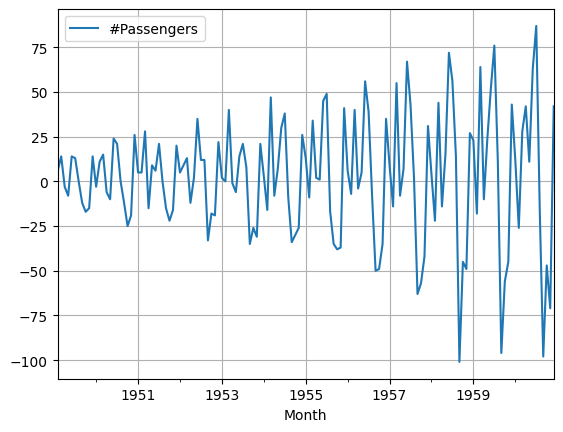

In [22]:
diff_df.plot(grid=True)

In [23]:
result = adfuller(diff_df)
# The result is a tuple that contains various test statistics and p-values
# You can access specific values as follows:
adf_statistic = result[0]
p_value = result[1]

# Print the results
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')

ADF Statistic: -2.8292668241700047
p-value: 0.05421329028382478


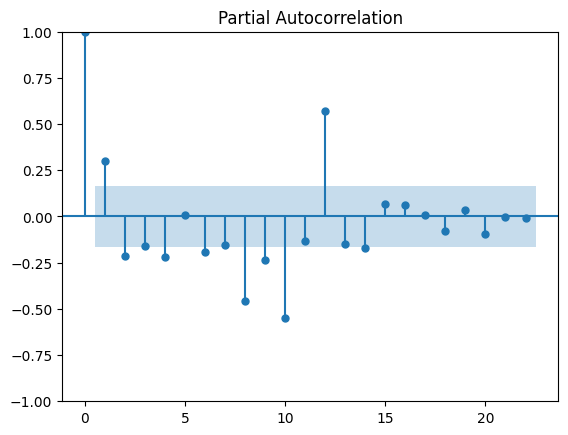

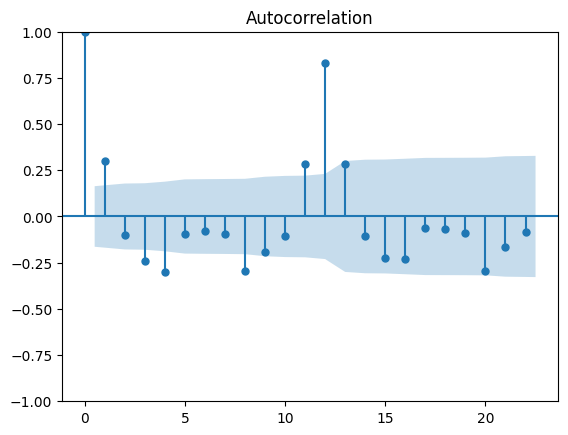

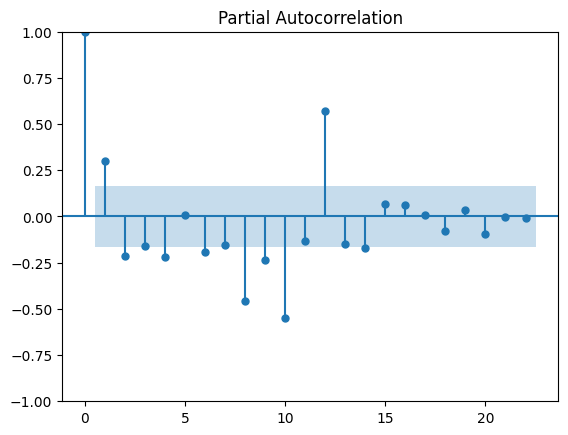

In [24]:
plot_acf(diff_df)
plot_pacf(diff_df)

# Single Exponential Smoothing

In [25]:
single_exp = SimpleExpSmoothing(train).fit()
single_exp_train_pred = single_exp.fittedvalues
single_exp_test_pred = single_exp.forecast(43)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [26]:
df.shape

(144, 1)

<Axes: xlabel='Month'>

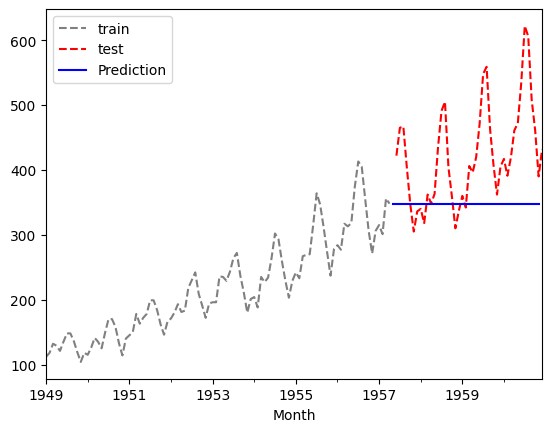

In [27]:
train['#Passengers'].plot(style='--', color='gray', legend=True, label='train')
test['#Passengers'].plot(style='--', color='r', legend=True, label='test')
single_exp_test_pred.plot(color='b', legend=True, label='Prediction')

In [28]:
Train_RMSE_SES = mean_squared_error(train, single_exp_train_pred)**0.5
Test_RMSE_SES = mean_squared_error(test, single_exp_test_pred)**0.5
Train_MAPE_SES = mean_absolute_percentage_error(train, single_exp_train_pred)
Test_MAPE_SES = mean_absolute_percentage_error(test, single_exp_test_pred)

print('Train RMSE :',Train_RMSE_SES)
print('Test RMSE :', Test_RMSE_SES)
print('Train MAPE :', Train_MAPE_SES)
print('Test MAPE :', Test_MAPE_SES)

Train RMSE : 23.47083303956671
Test RMSE : 106.96706722437959
Train MAPE : 0.08532342002218128
Test MAPE : 0.17254543771244724


# Double Exponential Smoothing

In [29]:
double_exp = ExponentialSmoothing(train, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()
double_exp_train_pred = double_exp.fittedvalues
double_exp_test_pred = double_exp.forecast(43)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='Month'>

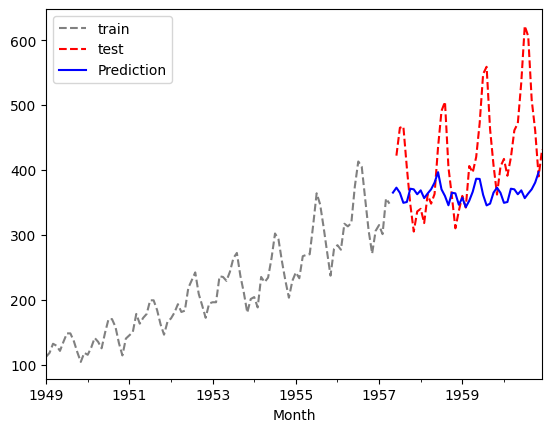

In [30]:
train['#Passengers'].plot(style='--', color='gray', legend=True, label='train')
test['#Passengers'].plot(style='--', color='r', legend=True, label='test')
double_exp_test_pred.plot(color='b', legend=True, label='Prediction')

In [31]:
Train_RMSE_DES = mean_squared_error(train, double_exp_train_pred)**0.5
Test_RMSE_DES = mean_squared_error(test, double_exp_test_pred)**0.5
Train_MAPE_DES = mean_absolute_percentage_error(train, double_exp_train_pred)
Test_MAPE_DES = mean_absolute_percentage_error(test, double_exp_test_pred)

print('Train RMSE :',Train_RMSE_DES)
print('Test RMSE :', Test_RMSE_DES)
print('Train MAPE :', Train_MAPE_DES)
print('Test MAPE :', Test_MAPE_DES)

Train RMSE : 23.283893193337274
Test RMSE : 94.57214255933388
Train MAPE : 0.07900374086543273
Test MAPE : 0.15438871066201712


# ARIMA

In [32]:
ar = ARIMA(train, order=(15,1,15)).fit()
ar_train_pred = ar.fittedvalues
ar_test_pred = ar.forecast(43)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

<Axes: xlabel='Month'>

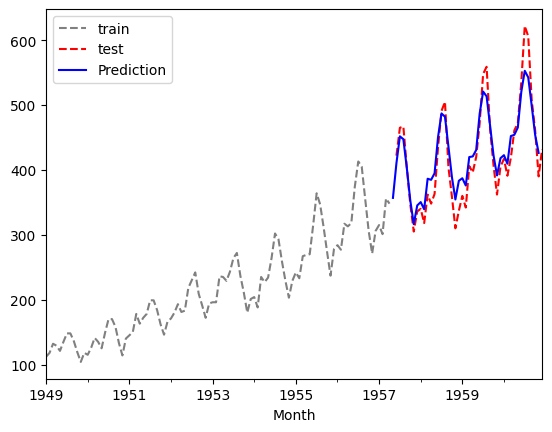

In [33]:
train['#Passengers'].plot(style='--', color='gray', legend=True, label='train')
test['#Passengers'].plot(style='--', color='r', legend=True, label='test')
ar_test_pred.plot(color='b', legend=True, label='Prediction')

In [34]:
Train_RMSE_AR = mean_squared_error(train, ar_train_pred)**0.5
Test_RMSE_AR = mean_squared_error(test, ar_test_pred)**0.5
Train_MAPE_AR = mean_absolute_percentage_error(train, ar_train_pred)
Test_MAPE_AR = mean_absolute_percentage_error(test, ar_test_pred)

print('Train RMSE :',Train_RMSE_AR)
print('Test RMSE :', Test_RMSE_AR)
print('Train MAPE :', Train_MAPE_AR)
print('Test MAPE :', Test_MAPE_AR)

Train RMSE : 14.20071832771583
Test RMSE : 45.285402548094446
Train MAPE : 0.04423659596567478
Test MAPE : 0.0929043309516595


# Perbandingan Algoritma

In [35]:
comparision_df = pd.DataFrame(data=[
    ['Single Exp Smoothing', Test_RMSE_SES, Test_MAPE_SES],
    ['Double Exp Smoothing', Test_RMSE_DES, Test_MAPE_DES],
    ['ARIMA', Test_RMSE_AR, Test_MAPE_AR]
    ],
    columns=['Model', 'RMSE', 'MAPE'])
comparision_df.set_index('Model', inplace=True)

In [36]:
comparision_df.sort_values(by='RMSE')

,RMSE,MAPE
Model,,
ARIMA,45.285403,0.092904
Double Exp Smoothing,94.572143,0.154389
Single Exp Smoothing,106.967067,0.172545


In [37]:
import pickle
pickle.dump(ar, open('forecast-ar.sav','wb'))